# Credit Card Fraud Analysis (Change this !!!!)

## [1] Sumary and introduction of the study


This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .This is an extract of the place holder text for the summary of the study taht is going to be in this .

## [2] Data study and general imports

In [25]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import Analysis_repo
from Analysis_repo import sourceCode
from matplotlib.ticker import ScalarFormatter

# Get the data form the Source code file
try:
    creditCard_p1_data = sourceCode.sendCreditCardData_part1() # credit card data part 1
    creditCard_p2_data = sourceCode.sendCreditCardData_part2() # credit card data part 2
    creditcardData_analysis = pd.concat([creditCard_p1_data, creditCard_p2_data]) # append the two parts of the credit card data together
    creditcardData_analysis.reset_index(drop=True, inplace=True)
except Exception as e:
    print("An exception occurred:", e)
    

In [26]:
# 1. Dimension of the datset
print("Rows: ", creditcardData_analysis.shape[0], "Cols: ", creditcardData_analysis.shape[1])

# 2. Data types to be observed in the dataset i.e., Dataset info
#creditcardData_analysis.info()


# 3. Checking for missing data in the dataset
missingDataCount =  creditcardData_analysis.isna().sum()
#missingDataCount


# 4. Distribution of Class type per transaction
class_dist = creditcardData_analysis['Class'].value_counts().head(3)
#class_dist 

# 5. Snippet of the data 
#creditcardData_analysis.head(2)


Rows:  90000 Cols:  31


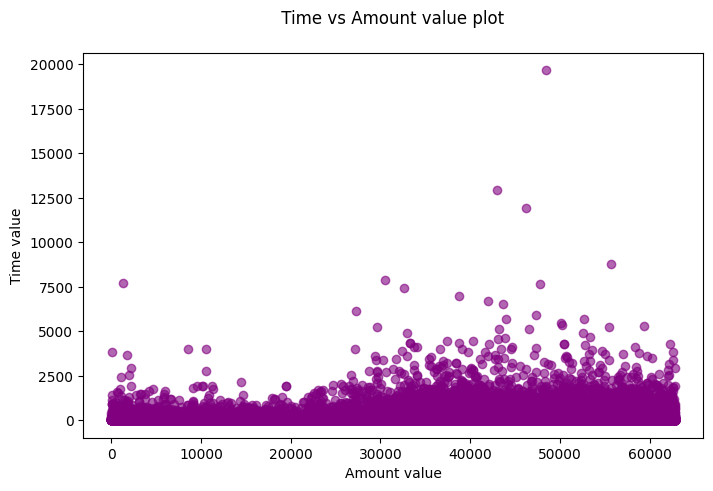

In [27]:
# 6 - Data Plot 1 - Plot of Transaction Amount versus the Time in which the transaction was created.
Amount_ = creditcardData_analysis["Amount"]
time = creditcardData_analysis["Time"]

plt.figure(figsize = (8, 5))
plt.scatter(time, Amount_, color='purple', alpha=0.6) # add # separate the data into clusters.
plt.ylabel("Time value")
plt.xlabel("Amount value")
plt.title(" Time vs Amount value plot \n")
plt.show()


# find a story to make this plot significant



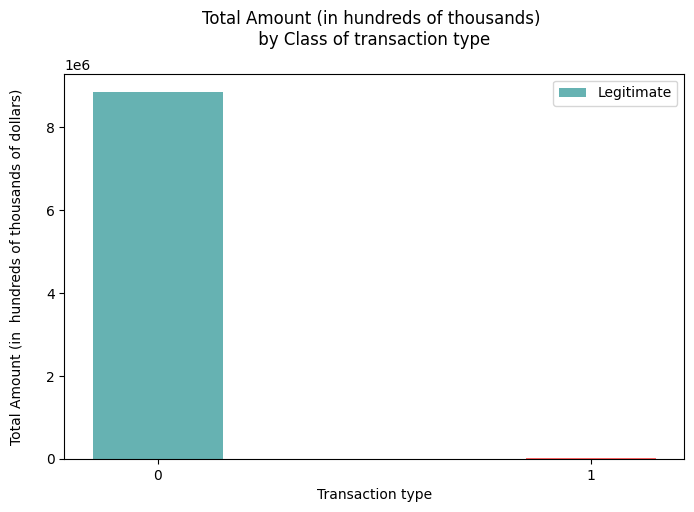

In [28]:
# 7 - Data plot 2 - Time versus Class plot (anything but the scatterplot) greta plot for grouping plots???

grouped_data = creditcardData_analysis.groupby('Class')['Amount'].sum().reset_index()

plt.figure(figsize = (8, 5))
plt.bar(grouped_data['Class'], grouped_data['Amount'] , color=['teal', 'red'], alpha=0.6, width=0.3)
plt.xticks(range(len(grouped_data['Class'])), grouped_data['Class']) # setting the x-axis transaction type values
#plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

# Plot information
plt.xlabel('Transaction type')
plt.ylabel('Total Amount (in  hundreds of thousands of dollars)\n')
plt.title('Total Amount (in hundreds of thousands) \n by Class of transaction type \n') 
plt.legend(['Legitimate', 'Fraudulent'])
plt.show()



# iif time is avaoilable work on making the full legend visible

## [3] Regression Modelling section


In this section we will look at creatign a linear regresson model out of our data to predict futre......
In this section we will look at creatign a linear regresson model out of our data to predict futre......
In this section we will look at creatign a linear regresson model out of our data to predict futre......
In this section we will look at creatign a linear regresson model out of our data to predict futre......
In this section we will look at creatign a linear regresson model out of our data to predict futre......


In [29]:
# Regression modelling imports

#from sklearn.model_selection import train_test_split <<< Should I use it >>>
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [30]:
# Forming a linear regression model for our study

#independent and dependent variables
Variable_inputs_X = creditcardData_analysis.drop("Class", axis=1) # Drop the class column
Output_domain_Y = creditcardData_analysis['Class'] # Get the data

# set seeds and generte random variables
i = np.random.choice(Output_domain_Y.index, size = len(Output_domain_Y), replace= False)
np.random.seed(19184914) # set seed

# Get interger vlaue of 70% the training set interger set size of
train_set_size = int(len(creditcardData_analysis) * 0.7)  
#print(train_set_size)

# train test split for the data points:
x_train = Variable_inputs_X.loc[i][:train_set_size]
y_train = Output_domain_Y.loc[i][:train_set_size]
   
x_test = Variable_inputs_X.loc[i][train_set_size:]
y_test = Output_domain_Y.loc[i][train_set_size:]

# Form a linear regression model
full_model = LinearRegression().fit(x_train, y_train) #form regression model.
full_model.coef_, full_model.intercept_

# print basic statistics:
print("Model Coefficients: \n", full_model.coef_)
print("\n Model Intercept:", round(full_model.intercept_, 5))


Model Coefficients: 
 [ 1.03526451e-08 -1.52504325e-03  2.48473336e-03 -4.76542207e-03
  3.67247778e-03 -1.58384424e-03 -1.54114037e-03 -5.51399774e-03
  3.45357039e-04 -3.43004808e-03 -7.69277380e-03  5.61364159e-03
 -1.00485576e-02 -4.24189658e-04 -1.23946355e-02 -1.40091572e-04
 -7.84623274e-03 -1.30334442e-02 -4.51748191e-03  1.40445637e-03
 -6.91778940e-05  1.47803079e-03  9.19575326e-04 -6.07006486e-05
 -2.87122571e-04  6.33686036e-04  1.46338842e-03 -4.13300287e-04
 -3.31828293e-04  5.85234284e-06]

 Model Intercept: 0.00134


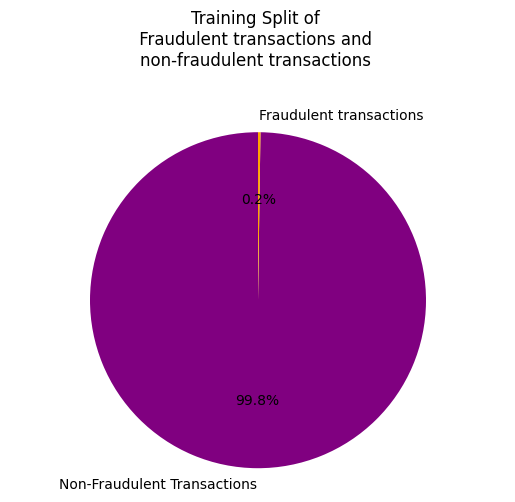

In [31]:
# Plots for the the training-testing data split
# 1 - Pie chart - Comparing the weight of fraud and non fraudulent transactions 
zero_count = (creditcardData_analysis['Class'] == 0).sum()
num_count = (creditcardData_analysis['Class'] == 1).sum()
fraud_class_labels = ['Non-Fraudulent Transactions', 'Fraudulent transactions']
transactions_sizes_weight = [zero_count, num_count]  # Transaction type sizes


# Pie Chart creation
plt.pie(transactions_sizes_weight, labels=fraud_class_labels, colors=['purple', 'orange'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Training Split of \n Fraudulent transactions and  \nnon-fraudulent transactions \n \n')


# Show the pie chart
plt.show()

#### Testing the effectiveness of the model

To test the model that has been trained, we compute statistics to help us analyze the effectiveness of teh model that has been created.
We form a regression model then trian it accoridngly. 

Areas of interest in our study:
1. $R^2$ value
2. Mean Square Error
3. Mean Absolute Error
4. $R^2$ range of comparison values
5. If $R_0^2 = 0.5$ is used; Comment on the effectiveness if the model.
6. Recommendations on the model and how can we improve the model by removing which variables?
7. Which explanatory variable does have the minimum and maximum linear relationships with the Class variable?
8. Improve the model by adding data to the new model. Has the new model been improved?
9. Import the _creditCardData-prediction_ and use the model in q8 to predict the transaction Class of the new _10000_ transactions. 
    * From the prediction data how many transactions are considered Fraudulent? Compare this value with the actual Fraudulent transactions in the dataset. 
10. Conclusion on findings

In [74]:
# 1. R^2 value

# Forming OLS regression
me_model = sm.OLS(y_train, x_train).fit()  

# Obtain the coefficient of determination and interpet it. Evaluate the model
y_pred = full_model.predict(x_test)
base_model_rsquared = r2_score(y_test, y_pred)
print("R-Squared: " , round(base_model_rsquared, 4), "\n")

# Get the train and test R2 values
r2_range = r2_score(y_train, me_model.predict(x_train)), r2_score(y_test, me_model.predict(x_test))
r2_train_test  = r2_range


# Findings:
print("Meaning of R-Squared: ")
percentage = round((base_model_rsquared * 100),2)
print("Using the model,", percentage,"% of the variance of Class value can be explained by the explanatory variables used in the model.")
print("The training vs. testing ranges are: ",round(r2_train_test[0], 4), round(r2_train_test[1], 4), "respectively.")


R-Squared:  0.5392 

Meaning of R-Squared: 
Using the model, 53.92 % of the variance of Class value can be explained by the explanatory variables used in the model.
The training vs. testing ranges are:  0.5345 0.5391 respectively.


In [33]:
#2. Mean Square Error

base_MSE_train = round(mean_squared_error(y_train, full_model.predict(x_train)),5)
base_MSE_test = round(mean_squared_error(y_test, full_model.predict(x_test)),5)

print("Train:", base_MSE_train, "Test:", base_MSE_test)


print(" Mean Square Error output:")
print("Train:", mean_squared_error(y_train, full_model.predict(x_train)), "Test:", mean_squared_error(y_test, full_model.predict(x_test)))
print(
    " Explaination.. is .....", '\n',
    "", '\n'  
)

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Class notes >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Train: 0.00107 Test: 0.00112
 Mean Square Error output:
Train: 0.001068723838144209 Test: 0.001123668205622702
 Explaination.. is ..... 
  



In [34]:
#3. Mean Absolute Error

base_MAE_train = round(mean_absolute_error(y_train, full_model.predict(x_train)),5)
base_MAE_test = round(mean_absolute_error(y_test, full_model.predict(x_test)),5)

print("Mean Absolute Error output:")
print("Train",base_MAE_train,"Test:",base_MAE_test)
print(
    " Explaination.. is .....", '\n',
    "", '\n'  
)

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Class notes >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


Mean Absolute Error output:
Train 0.00386 Test: 0.00401
 Explaination.. is ..... 
  



In [47]:
#4. R^2 range of comparison values

base_R2_train = round(r2_score(y_train, full_model.predict(x_train)),5)
base_R2_test = round(r2_score(y_test, full_model.predict(x_test)),5)


print("R^2 value output:")
print("Train", base_R2_train,"Test", base_R2_test)
print(
    "The training and testing values of r2 are very close to one another.", '\n',
    "This illustrates to us that the model is either accurately working well or accurately not working well with the data.", '\n'  
    "", '\n'  
    "", '\n'  
)




# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Class notes >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

R^2 value output:
Train 0.53459 Test 0.53917
Explaination.. is ..... 
  



In [61]:
#5. If R0^2 = 0.5 is used a barometer for models; Comment on the effectiveness of the model.


r0_value = 0.5

print(
    "Using the value of R0=", r0_value,"and the value of R2 =",base_R2_test,"as the vlaues of comparision, we can conclude that:" '\n',
    "Our model is acceptable for use since our tested R2 is greater than the R0^2 value given", '\n',
    "The model is also a good fit since the values of R2_train and R2_test are",base_R2_train,"and",base_R2_train,"respectively", '\n',
    "The narrow range between the values illustrate this to us.", '\n'  
)


Using the value of R0= 0.5 and the value of R2 = 0.53917 as the vlaues of comparision, we can conclude that:
 Our model is acceptable for use since our tested R2 is greater than the R0^2 value given 
 The model is also a good fit since the values of R2_train and R2_test are 0.53459 and 0.53459 respectively 
 The narrow range between the values illustrate this to us. 



In [60]:
# 6. Recommendations on the model and how can we improve the model?
print(
    "From question 5 we can deduce that the model is a good fit, however this does not mean the model cannot be improved.", '\n',
    "Possible ways of improving the model include:", '\n',
    "1. Adding more transaction data to the model.", '\n',
    "2. Removing variables that have a low linear relationship with the 'Class' variable and finding the 'right mix' of variables for our regression analysis.", '\n'
)


From question 5 we can deduce that the model is a good fit, however this does not mean the model cannot be improved. 
 Possible ways of improving the model include: 
 1. Adding more transaction data to the model. 
 2. Removing variables that have a low linear relationship with the 'Class' variable and finding the 'right mix' of variables for our regression analysis. 



In [38]:
# 7. Which explanatory variable does have the highest and min linear relationships with the Class variable?

# get the correlation series of each explanaotry variable with MedHouseVal
explanatory_correlation_series = creditcardData_analysis.corr()['Class'].drop('Class')
max_cor = explanatory_correlation_series.idxmax()
min_cor = explanatory_correlation_series.idxmin()

# Output
print("Variables having the min and the max linear relationship with `Class` are", min_cor, "and",max_cor,"respectively.")

Variables having the min and the max linear relationship with `Class` are V17 and V11 respectively.


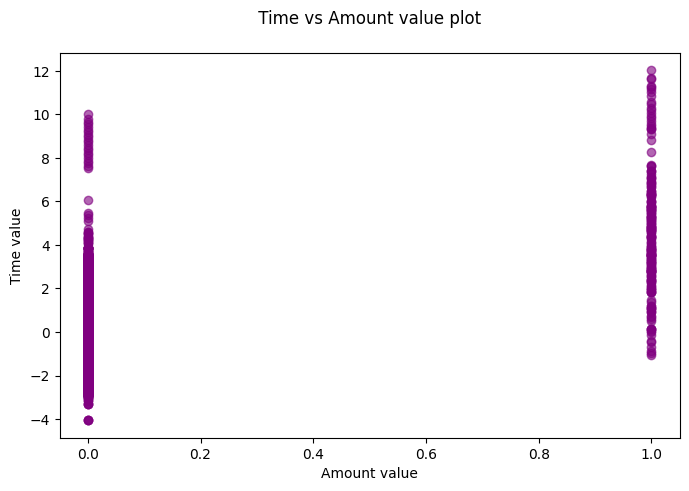

In [39]:
#  plot to show this relationships 1

Amount_ = creditcardData_analysis["Class"]
v11 = creditcardData_analysis["V11"]

plt.figure(figsize = (8, 5))
plt.scatter(Amount_, v11, color='purple', alpha=0.6) # add # separate the data into clusters.
plt.ylabel("Time value")
plt.xlabel("Amount value")
plt.title(" Time vs Amount value plot \n")
plt.show()


# <<<<<<<<<<<<< Chnage the plot >>>>>>>>>


In [59]:
# 8. Improve the model by adding data to the new model. Has the new model been improved?

np.random.seed(191849142) # set seed


#independent and dependent variables
Variable_inputs_X = creditcardData_analysis.drop(["Class"], axis=1)
Output_domain_Y = creditcardData_analysis['Class']

# add new data to the model; set seeds and generte random variables
# set seeds and generte random variables
boosted_i = np.random.choice(Output_domain_Y.index, size = len(Output_domain_Y), replace= False)

boosted_training_set_n = int(len(creditcardData_analysis) * 0.8)


boosted_x_train = Variable_inputs_X.loc[boosted_i][:boosted_training_set_n]
boosted_y_train = Output_domain_Y.loc[boosted_i][:boosted_training_set_n]


boosted_x_test = Variable_inputs_X.loc[boosted_i][boosted_training_set_n:]
boosted_y_test = Output_domain_Y.loc[boosted_i][boosted_training_set_n:]

# fit model with new data
boosted_model = LinearRegression().fit(boosted_x_train, boosted_y_train)

# Predict the R2, MAE, MSE values
booosted_y_pred = boosted_model.predict(boosted_x_test)
boosted_model_rsquared = round(r2_score(boosted_y_test, booosted_y_pred),5)

boosted_MAE_train = round(mean_absolute_error(y_train, full_model.predict(x_train)),5)
boosted_MAE_test = round(mean_absolute_error(y_test, full_model.predict(x_test)),5)

boosted_MSE_train = round(mean_squared_error(y_train, full_model.predict(x_train)),5)
boosted_MSE_test = round(mean_squared_error(y_test, full_model.predict(x_test)),5)



# Model comparision from me_model vs boosted_model
print("R-Squared comparison: ")
print("The value of RSquared between models changed from ", round(base_model_rsquared,5), "to", boosted_model_rsquared, "in the boosted model")
print("From the base model to the boosted model teh R2 value improved significantly from by",round(boosted_model_rsquared - base_model_rsquared, 4) ,"points", "\n")

print("MSE comaprison: ")
print("The test value of MSE  between models changed from", base_MSE_test ,"to", boosted_MSE_test, "in the boosted model")
print("As we can observe from the mean squared error of the model remained the same even when we added new data and boosted  the model \n")

print("MAE comparison: ")
print("The test value of MAE between models changed from", base_MAE_test, "to", boosted_MAE_test, "in the boosted model")
print("IN booth instances of the base and booosted model the mean absoluate error of the models remained the same")


R-Squared comparison: 
The value of RSquared between models changed from  0.53917 to 0.58359 in the boosted model
From the base model to the boosted model teh R2 value improved significantly from by 0.0444 points 

MSE comaprison: 
The test value of MSE  between models changed from 0.00112 to 0.00112 in the boosted model
As we can observe from the mean squared error of the model remained the same even when we added new data and boosted  the model 

MAE comparison: 
The test value of MAE between models changed from 0.00401 to 0.00401 in the boosted model
IN booth instances of the base and booosted model the mean absoluate error of the models remained the same


In [45]:
# 9. Import the creditCardData_prediction and use the model in q8 to predict the transaction Class of the new 10000 transactions. 

try:
    creditcardData_prediction_data = sourceCode.sendPredictionDataset()
except Exception as e:
    print("An exception occurred:", e)
    
mod_predict_data = creditcardData_prediction_data.drop("Class", axis=1)
mod_actual_class_data = creditcardData_prediction_data["Class"]

booosted_y_pred = boosted_model.predict(mod_predict_data)

predict_class_list = []

for value in booosted_y_pred:
    int_value = int(value)
    predict_class_list.append(int(value))
    

# predicted list
#|print(predict_class_list)
# 9.1 - From the prediction data how many transactions are considered Fraudulent?
pred_fraudent_transactions = len([value for value in predict_class_list if value == 1])
print("The model predicts that:", pred_fraudent_transactions, "fraudulent transactions in the dataset")

# 9.2 -  Compare this value with the actual Fraudulent transactions in the dataset.
actual_fraudent_transactions = len([value for value in mod_actual_class_data if value == 1])
print("The actual count of class data is:", actual_fraudent_transactions)


The model predicts that: 38 fraudulent transactions in the dataset
The actual count of class data is: 63


In [6]:
# 10. Conclusion on findings
print(
    "", '\n',
    "", '\n',
    "", '\n',
    "", '\n'  
)


## > Decision Tree Modelling section


#### librarey and short summary of section>>>>

'''''''''''"

- Why i am using decision tree model?
- The benefits of using the model?
- 

''''''''''''

In [ ]:
# Decision tree modellign section imports
from sklearn.tree import export_text


In [ ]:
# # start decision tree
# clf = DecisionTreeClassifier()
# clf.fit(x_train, y_train)


# # make prictions on teh data
# y_pred = clf.predict(x_test)


# accuracy = accuracy_score(y_test, y_pred)
# confusion = confusion_matrix(y_test, y_pred)
# print(f'Accuracy: {accuracy}')
# print(f'Confusion Matrix:\n{confusion}')



In [ ]:
# plot the decision tree model <Chnage  athe plot to a nice looking plot>



tree_rules = export_text(clf, feature_names=list(Variable_inputs_X.columns))
print(tree_rules)


## Neural networks section

In [ ]:
## Under construction

In [ ]:
import tensorflow as tf

# Load or generate your training data


# get size of the datset
train_set_size = int(len(creditcardData_analysis) * 0.7) #make sure this value is an int for indexiing purposes
print(train_set_size)


# # For this example, let's assume you have features (X_train) and labels (y_train).

# # Define the neural network architecture
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(train_set_size,)),  # Define the input shape
#     tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
#     tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit (for binary classification) and sigmoid activation
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(x_train, y_train, epochs=10, batch_size=32)

# # Evaluate the model on a test dataset
# # X_test and y_test are your test data and labels
# loss, accuracy = model.evaluate(x_test, y_test)
# print(f'Test accuracy: {accuracy * 100:.2f}%')
